# Visualize the results

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os, re
import util

from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib notebook

## Plot Embeddings

In [2]:
def restore_emb(config, train_dir):
    print 'Restoring graph...',
    with tf.Graph().as_default():
        with tf.variable_scope('cnn'):
            if config.has_key('split') and config['split']:
                import cnn_context
                m = cnn_context.Model(config, is_train=False)
            else:
                import cnn
                m = cnn.Model(config, is_train=False)
        saver = tf.train.Saver(tf.all_variables())

        with tf.Session() as sess:
            ckpt = tf.train.get_checkpoint_state(train_dir)
            saver.restore(sess, ckpt.model_checkpoint_path)
            
            embeddings = sess.run(tf.all_variables())
    print 'done.'        
    if config.has_key('split') and config['split']:
        return embeddings[:2]
    else:
        return embeddings[0]

In [3]:
def get_2d_emb(embeddings, limit=None):
    print 'Reducing dimension...',
    if limit:
        embeddings = embeddings[2:limit+2] # skip <pad> and <unk>
    norm = np.sqrt(np.sum(np.square(embeddings), axis=0))
    normalized_embeddings = embeddings / norm
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    two_d_embeddings = tsne.fit_transform(normalized_embeddings)
    print 'done.'
    return two_d_embeddings

In [4]:
def construct_emb_df(data_dir, two_d_embeddings):
    print 'Loading vocabulary...',
    vocab_path = os.path.join(data_dir, 'vocab.txt')
    word2id, _ = util.initialize_vocabulary(vocab_path)
    limit = len(two_d_embeddings)
    keys, values = word2id.keys()[2:limit+2], word2id.values()[2:limit+2]
    word = pd.DataFrame({'word': keys}, index=values)
    values = pd.DataFrame(two_d_embeddings, columns=['x', 'y'])
    emb_df = pd.concat([word, values], axis=1)
    emb_df = emb_df[pd.notnull(emb_df.x)]
    print 'done.'
    return emb_df

In [5]:
def plot_emb(df, anno=True, limit=None, 
             title='Embeddings', xlim=None, ylim=None):
    ax = df.plot(kind="scatter", x='x', y='y')
    # annotate labels
    if anno:
        for index, row in df.iterrows():
            if limit and index % limit != 0:
                continue
            ax.annotate(row['word'], xy=(row['x'], row['y']))
            
    ax.set_xlabel('')
    ax.set_ylabel('')
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    ax.set_title(title)
    fig = ax.get_figure()
    return fig

Restoring graph... done.
Reducing dimension... done.
Loading vocabulary... done.


<IPython.core.display.Javascript object>


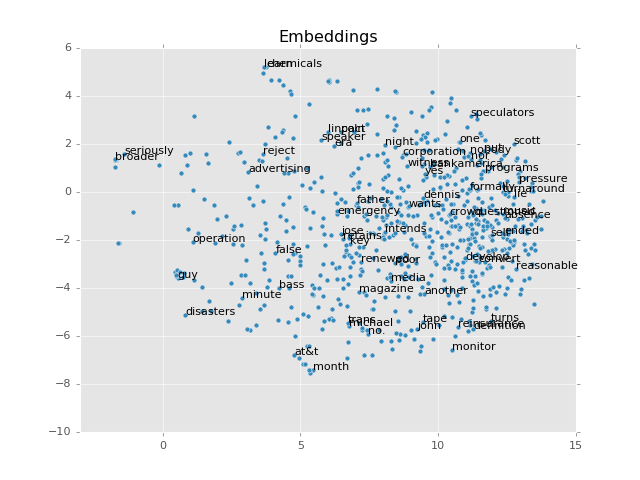

In [6]:
train_dir = './train/1475601912'
config = util.load_from_dump(os.path.join(train_dir, 'flags.cPickle'))
data_dir = './data'

emb = restore_emb(config, train_dir)
two_d_emb = get_2d_emb(emb, limit=5000)
df = construct_emb_df(data_dir, two_d_emb)
df = df[pd.notnull(df.word)]
fig_emb = plot_emb(df, limit=10, xlim=(-3, 15))
fig_emb.savefig(os.path.join(train_dir, 'emb.pdf'))

## Plot Precision-Recall Curve

In [2]:
def plot_pr_curve(train_dirs, colors, labels, points, xlim=None, ylim=None):
    
    for i, train_dir in enumerate(train_dirs):
        results = util.load_from_dump(os.path.join(train_dir, 'results.cPickle'))
        plt.plot(results['recall'], results['precision'], points[i], 
                 color=colors[i], label=labels[i])
        
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    #plt.legend(loc='upper right')
    plt.legend(loc='lower right')
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.show()
    return plt

<IPython.core.display.Javascript object>


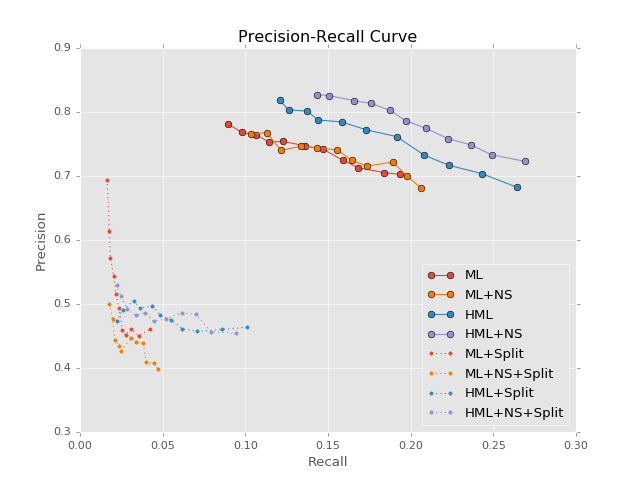

In [3]:
train_dirs = ['./train/1475593484', './train/1475601157', 
              './train/1475594193', './train/1475601912', 
              './train/1475589902', './train/1475599325', 
              './train/1475590775', './train/1475600242']
colors = ['#E24A33', '#F57C00', '#348ABD', '#988ED5', 
          '#E24A33', '#F57C00', '#348ABD', '#988ED5']
labels = ['ML', 'ML+NS', 'HML', 'HML+NS', 
          'ML+Split', 'ML+NS+Split', 'HML+Split', 'HML+NS+Split']
points = ['o-', 'o-', 'o-', 'o-', '.:', '.:', '.:', '.:']
fig_pr = plot_pr_curve(train_dirs, colors, labels, points)
fig_pr.savefig(os.path.join(os.getcwd(), 'train', 'pr_curve.pdf'))

## Classification report

In [6]:
def report(train_dirs, models):
    ret = '                    P       R      F1      AUC\n'
    for i, train_dir in enumerate(train_dirs):
        results = util.load_from_dump(os.path.join(train_dir, 'results.cPickle'))
        pre = results['precision'][5]
        rec = results['recall'][5]
        f1 = (2.0 * pre * rec) / (pre + rec)
        auc = util.calc_auc_pr(results['precision'], results['recall'])
        ret += '%15s  %.4f  %.4f  %.4f  %.4f\n' % (models[i], pre, rec, f1, auc) 
    return ret

In [7]:
print report(train_dirs, labels)

                    P       R      F1      AUC
             ML  0.7473  0.1360  0.2301  0.4399
          ML+NS  0.7406  0.1557  0.2573  0.4370
            HML  0.7722  0.1732  0.2829  0.4685
         HML+NS  0.7862  0.1972  0.3153  0.4930
       ML+Split  0.4932  0.0237  0.0451  0.2469
    ML+NS+Split  0.4476  0.0309  0.0578  0.2156
      HML+Split  0.4828  0.0486  0.0883  0.2622
   HML+NS+Split  0.4732  0.0445  0.0813  0.2573



## Plot Train Log

In [2]:
def plot_log(train_dirs, colors, models, name, xlim=None, ylim=None):
    
    fig, ax = plt.subplots(1, 1)
    for i, train_dir in enumerate(train_dirs):
        train = pd.read_csv(os.path.join(train_dir, 'train_%s.csv' % name),
            index_col=1, names=['time', 'train_%s' % models[i]], skiprows=[0])
        dev = pd.read_csv(os.path.join(train_dir, 'dev_%s.csv' % name), 
            index_col=1, names=['time', 'dev_%s' % models[i]], skiprows=[0])      
        
        ax = train['train_%s' % models[i]].plot(style='--', legend=True, 
                                                color=colors[i], ax=ax)
        ax = dev['dev_%s' % models[i]].plot(legend=True, 
                                            color=colors[i], ax=ax)
        ax.set_xlabel('Step')
        ax.set_ylabel(name.upper())
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
        ax.set_title(name.upper())
    return fig

<IPython.core.display.Javascript object>


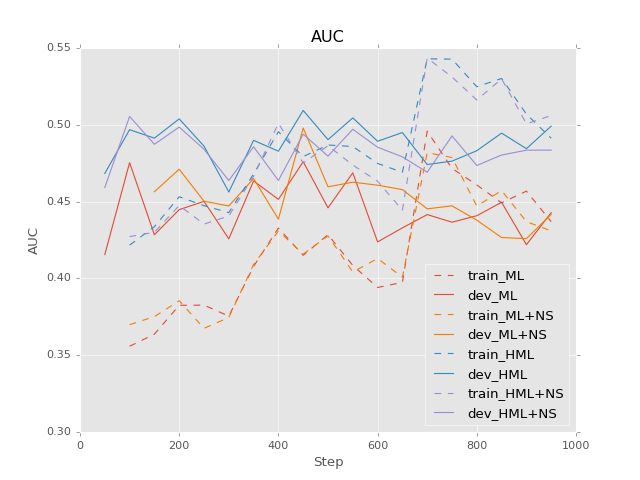

In [3]:
train_dirs = ['./train/1475593484', './train/1475601157', 
              './train/1475594193', './train/1475601912']
colors = ['#E24A33', '#F57C00', '#348ABD', '#988ED5']
models = ['ML', 'ML+NS', 'HML', 'HML+NS']
fig_auc = plot_log(train_dirs, colors, models, 'auc', 
                   xlim=(0, 1000), ylim=(0.3, 0.55))
fig_auc.savefig(os.path.join(os.getcwd(), 'train', 'auc.pdf'))

<IPython.core.display.Javascript object>


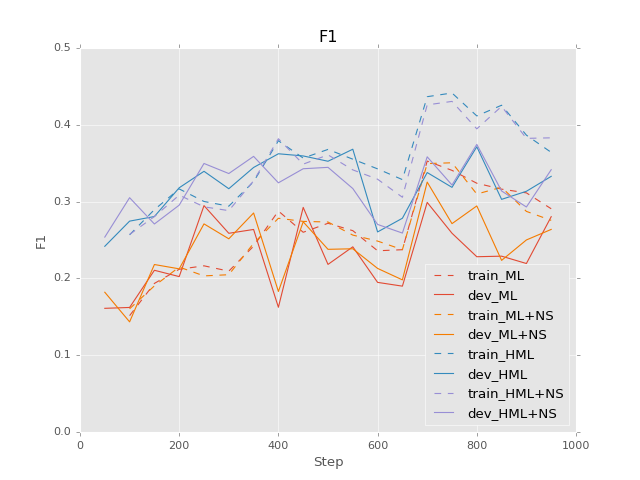

In [4]:
fig_f1 = plot_log(train_dirs, colors, models, 'f1', 
                  xlim=(0, 1000), ylim=(0, 0.5))
fig_f1.savefig(os.path.join(os.getcwd(), 'train', 'f1.pdf'))

<IPython.core.display.Javascript object>


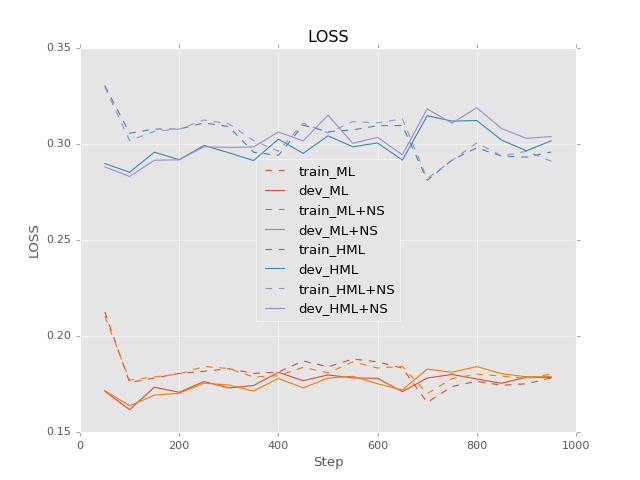

In [5]:
fig_loss = plot_log(train_dirs, colors, models, 'loss', 
                    xlim=(0, 1000), ylim=(0.15, 0.35))
fig_loss.savefig(os.path.join(os.getcwd(), 'train', 'loss.pdf'))